# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap


In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [4]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [5]:
def remove_moa(df):
    pipes = ['EGFR inhibitor|protein tyrosine kinase inhibitor',
             'cyclooxygenase inhibitor|prostanoid receptor',
             'aromatase inhibitor|TRPV antagonist',
             'DNA synthesis inhibitor|thymidylate synthase inhibitor',
            'apoptosis stimulant|ribonucleotide reductase inhibitor']    
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [6]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['train']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_sample').reindex(index=data_dict['valid']['Metadata_broad_sample']).reset_index().drop('Metadata_broad_sample',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(7961, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [8]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [9]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [10]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [11]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=30,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam=1000,
    verbose=True,
)
#100000
#10000
#200 ep 1000000 results in 1.20
cp_vae.compile_vae()

In [12]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/30
83/83 [==============================] - 4s 17ms/step - loss: 80.3286 - recon: 30.7550 - kl: 0.0000e+00 - mmd: 11.5791 - val_loss: 44.5638 - val_recon: 12.7566 - val_kl: 0.0000e+00 - val_mmd: 30.1584
Epoch 2/30
83/83 [==============================] - 0s 6ms/step - loss: 17.0356 - recon: 8.1249 - kl: 0.0000e+00 - mmd: 6.9009 - val_loss: 51.7024 - val_recon: 9.1511 - val_kl: 0.0000e+00 - val_mmd: 45.5026
Epoch 3/30
83/83 [==============================] - 0s 6ms/step - loss: 12.2032 - recon: 6.3632 - kl: 0.0000e+00 - mmd: 5.1322 - val_loss: 29.5038 - val_recon: 6.4826 - val_kl: 0.0000e+00 - val_mmd: 24.1827
Epoch 4/30
83/83 [==============================] - 0s 6ms/step - loss: 9.9519 - recon: 5.4022 - kl: 0.0000e+00 - mmd: 4.3118 - val_loss: 30.5950 - val_recon: 5.7874 - val_kl: 0.0000e+00 - val_mmd: 23.2930
Epoch 5/30
83/83 [==============================] - 0s 6ms/step - loss: 8.5374 - recon: 4.6813 - kl: 0.0000e+00 - mmd: 4.2753 - val_loss: 19.7993 - val_recon: 4.1329 - v

In [13]:
cp_vae.vae

In [14]:
# cp_vae.vae.evaluate(test_features_df)

In [15]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,42.147285,30.755041,0.0,11.579074,44.563797,12.756624,0.0,30.158400
1,15.204253,8.124857,0.0,6.900898,51.702374,9.151106,0.0,45.502617
2,11.394036,6.363245,0.0,5.132244,29.503759,6.482577,0.0,24.182709
3,9.836094,5.402174,0.0,4.311791,30.594952,5.787410,0.0,23.292986
4,8.888240,4.681338,0.0,4.275317,19.799259,4.132949,0.0,16.439730
5,8.354700,4.311398,0.0,3.902535,19.295710,3.934570,0.0,14.535816
6,7.787882,4.068022,0.0,3.734396,25.681631,3.865150,0.0,24.039972
7,7.648081,3.922436,0.0,3.807351,10.426530,3.657510,0.0,8.032680
8,8.087871,3.864417,0.0,4.057618,10.393656,3.793966,0.0,7.911876
9,7.885864,3.894584,0.0,3.916855,21.404190,3.637060,0.0,17.085451


In [16]:
history_df.to_csv('level5_training_mmd_leaveOut.csv')

In [17]:
# history_df = pd.read_csv('level5_training.csv')

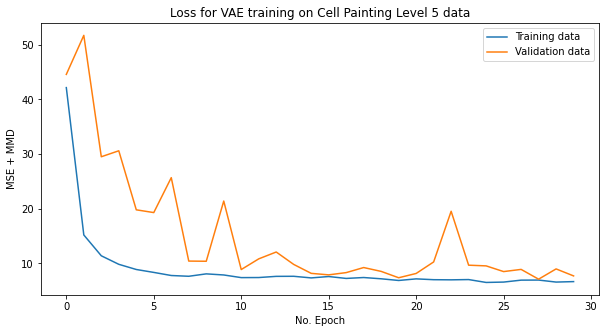

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + MMD")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [19]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

54.34379114386869

<AxesSubplot:>

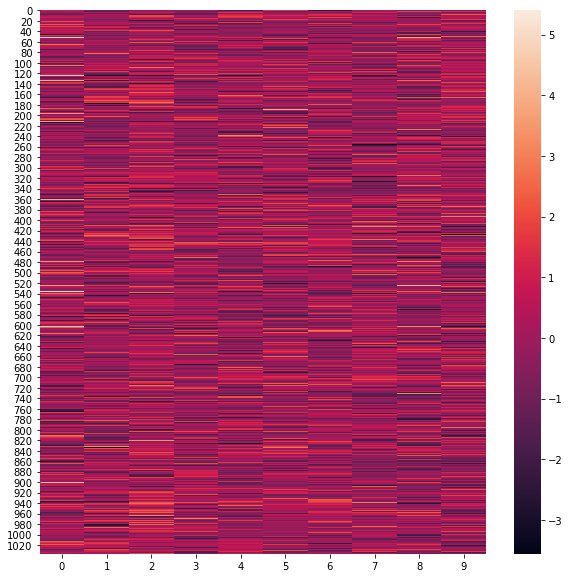

In [20]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:
pd.DataFrame(encoder.predict(test_features_df)[2]).mean()

0    0.020184
1   -0.034880
2    0.252691
3   -0.037009
4   -0.048139
5    0.064951
6   -0.016192
7    0.020511
8   -0.121525
9    0.054545
dtype: float32

In [22]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

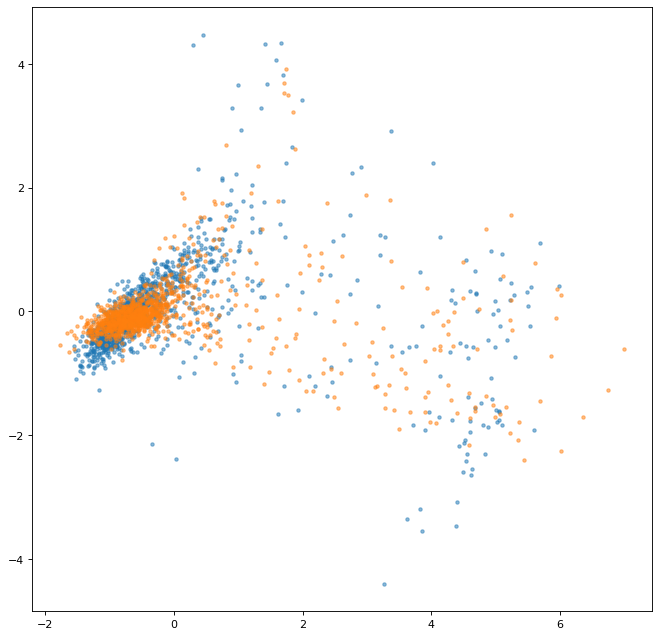

In [23]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [24]:
pca = PCA(n_components=50).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

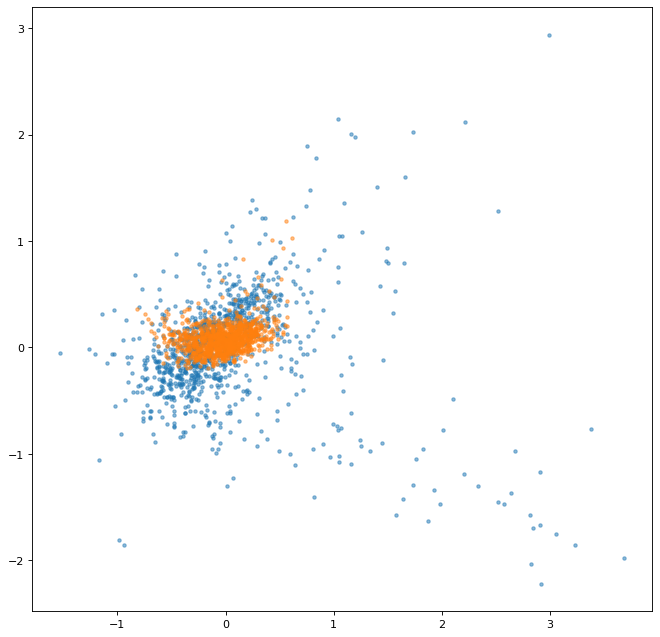

In [25]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[2],pca_test_latent_df[3], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[2],pca_reconstructed_latent_df[3], marker = ".", alpha = 0.5)

In [273]:
# decoder = keras.models.load_model("level5Decoder")
# encoder = keras.models.load_model("level5Encoder")

In [251]:
# reconstruction = decoder.predict(encoder.predict(test_features_df)[2])

In [26]:
import umap
reducer = umap.UMAP().fit(test_features_df)
original_test_embedding = reducer.transform(test_features_df)
reconstructed_test_embedding = reducer.transform(reconstruction)

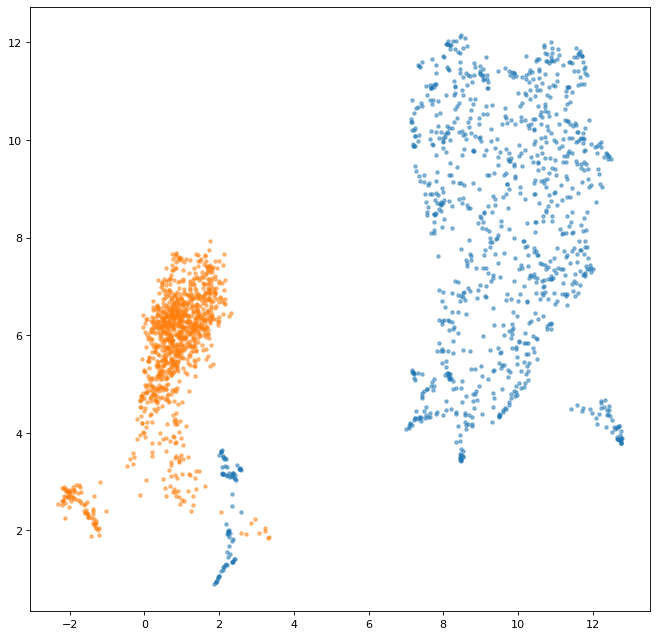

In [27]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(original_test_embedding[:,0],original_test_embedding[:,1], marker = ".", alpha = 0.5)
plt.scatter(reconstructed_test_embedding[:,0],reconstructed_test_embedding[:,1], marker = ".", alpha = 0.5)

<AxesSubplot:>

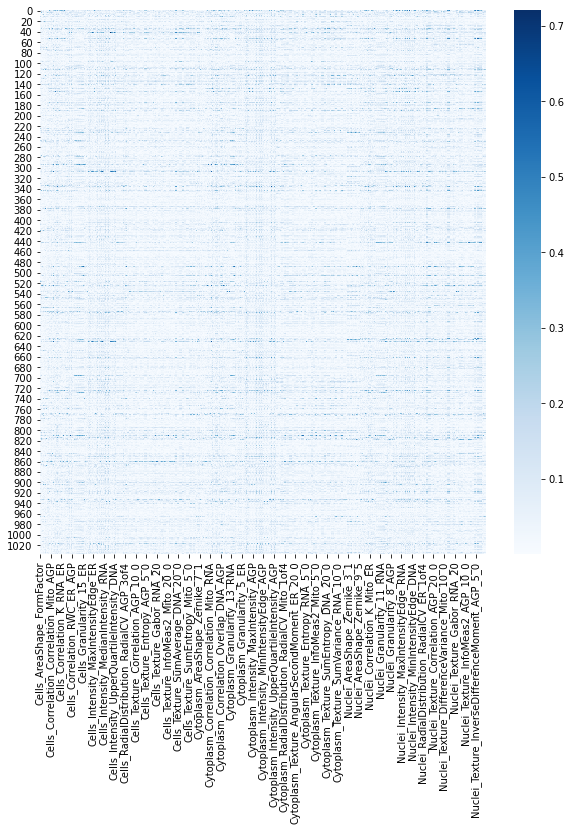

In [389]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

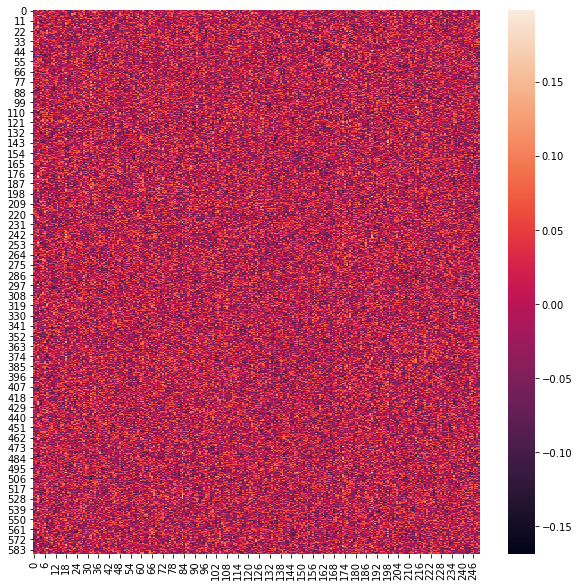

In [390]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [28]:
decoder = cp_vae.decoder_block["decoder"]

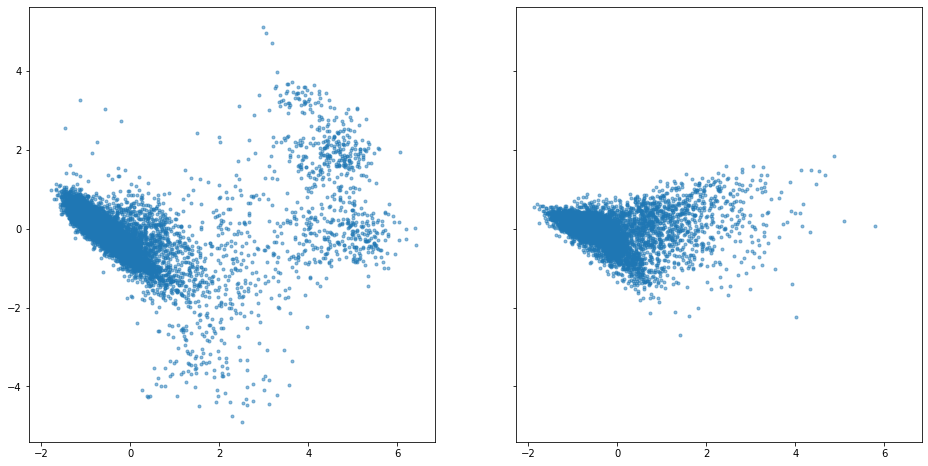

In [29]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [30]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(train_features_df, reconstruction_of_simulated)[0],directed_hausdorff(reconstruction_of_simulated,train_features_df)[0])

6.121585586286412

In [362]:
# decoder = keras.models.load_model("level5Decoder")

In [31]:
import umap
reducer = umap.UMAP()
original_test_embedding = reducer.fit_transform(test_features_df)

In [32]:
simulated_test_df = pd.DataFrame(np.random.normal(size=(1037, 10)), columns=np.arange(0,10))
reconstruction_of_simulated_test = decoder.predict(simulated_test_df)

In [33]:
simulated_embedding = reducer.transform(reconstruction_of_simulated_test)

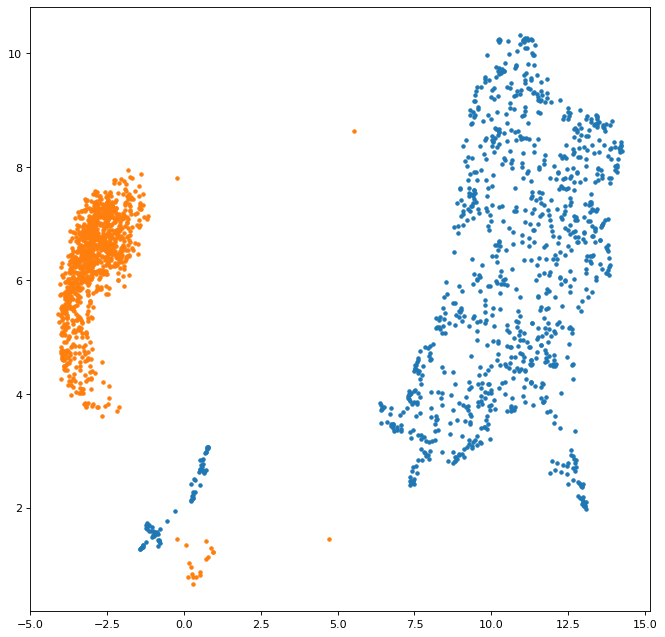

In [34]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    original_test_embedding[:, 0],
    original_test_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
plt.scatter(
    simulated_embedding[:, 0],
    simulated_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the cell painting level 5 test set')

In [35]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent_mmd_leaveOut.csv")

In [36]:
reducer = umap.UMAP()
latent_embedding = reducer.fit_transform(latent_df)

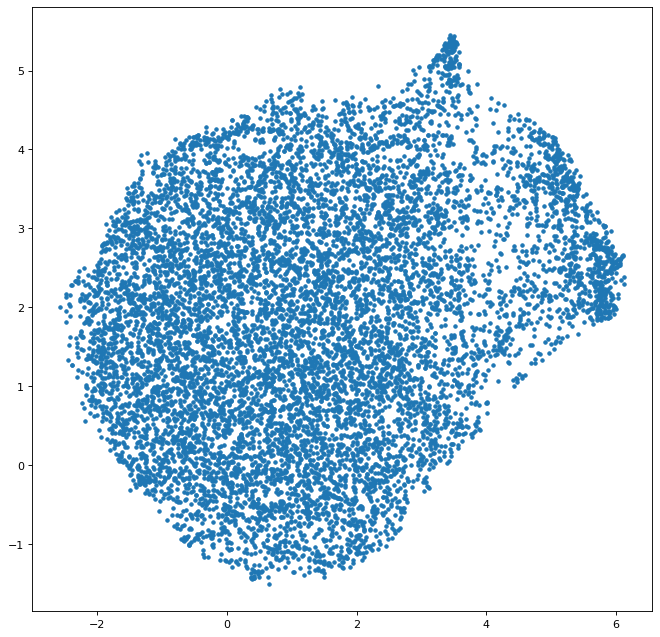

In [37]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    latent_embedding[:, 0],
    latent_embedding[:, 1],
    marker = '.'
)

In [38]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("level5Decoder_mmd_leaveOut")

INFO:tensorflow:Assets written to: level5Decoder_mmd_leaveOut/assets


In [39]:
encoder.save("level5Encoder_mmd_leaveOut")

INFO:tensorflow:Assets written to: level5Encoder_mmd_leaveOut/assets
